# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: LightGBM Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. LightGBM Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'boost_from_average': False, 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "TEST" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = True # <== Set as True if you'll be training a tuned model.

HYPERPARAMS = "{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'boost_from_average': False, 'auto_class_weights': 'Balanced'}"
HYPERPARAMS_FILE = "catb_sample_tune.txt" # <== Pointing a file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(HYPERPARAMS_FILE) != 0:
        f = open(HYPERPARAMS_FILE, "r")
        HYPERPARAMS = f.readline()
        f.close()
    HYPERPARAMS = HYPERPARAMS.replace('\'', '\"')
    HYPERPARAMS = HYPERPARAMS.replace("False", "\"False\"")
    HYPERPARAMS = HYPERPARAMS.replace("True", "\"True\"")
    HYPERPARAMS = json.loads(str(HYPERPARAMS))
    for key in HYPERPARAMS:
        if HYPERPARAMS[key] == "False":
            HYPERPARAMS[key] = False
        if HYPERPARAMS[key] == "True":
            HYPERPARAMS[key] = True
    print("Parsed Hyperparams:", HYPERPARAMS)
    
start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def startTime():
    global start
    start = time.time()
def endTime(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed Hyperparams: {'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'boost_from_average': False, 'auto_class_weights': 'Balanced'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/TB_CATB.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train = "../Dataset/IB/IB_CATB.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for LightGBM

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (4574, 101)
IB Train Size: (4574, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrGetDllHandle,GetSystemInfo,NtDelayExecution,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NtClose,NtAllocateVirtualMemory,RegOpenKeyExW,RegCloseKey,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegCloseKey,RegQueryValueExW,RegCloseKey
1,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos
2,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrGetProcedureAddress,GetSystemMetrics,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryW,LdrLoadDll,CreateThread,FindResourceExW,NtClose,GetSystemMetrics


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrGetDllHandle,GetSystemInfo,NtDelayExecution,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetProcedureAddress,CreateToolhelp32Snapshot,Thread32First,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetSystemDirectoryW,NtDelayExecution,LdrLoadDll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,SHGetFolderPathW,SetErrorMode,GetFileAttributesW,CreateDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def getIndexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setupModel():
    global HYPERPARAMS
    global TUNED_TRAINING
    indexes = getIndexes()
    if TUNED_TRAINING:
        return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min')
    return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min')

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
startTime()
tb_catb = setupModel()
tb_catb.fit(X_tb_training, y_tb_training)
endTime("CATB_Time-Based")

#Saving Model as file
dump(tb_catb, "Outputs/"+MODEL_FILENAME+"_TB_CATB.joblib")

0:	learn: 0.5489494	total: 203ms	remaining: 9.93s
1:	learn: 0.4437323	total: 247ms	remaining: 5.92s
2:	learn: 0.3004461	total: 603ms	remaining: 9.45s
3:	learn: 0.2252200	total: 668ms	remaining: 7.68s
4:	learn: 0.1582761	total: 732ms	remaining: 6.58s
5:	learn: 0.1186545	total: 859ms	remaining: 6.3s
6:	learn: 0.0983638	total: 903ms	remaining: 5.54s
7:	learn: 0.0830706	total: 1.67s	remaining: 8.77s
8:	learn: 0.0678534	total: 1.76s	remaining: 8.01s
9:	learn: 0.0607259	total: 1.81s	remaining: 7.26s
10:	learn: 0.0549137	total: 1.88s	remaining: 6.65s
11:	learn: 0.0517428	total: 1.91s	remaining: 6.06s
12:	learn: 0.0485137	total: 2.02s	remaining: 5.76s
13:	learn: 0.0426352	total: 2.24s	remaining: 5.76s
14:	learn: 0.0394396	total: 2.43s	remaining: 5.68s
15:	learn: 0.0372180	total: 2.49s	remaining: 5.3s
16:	learn: 0.0349302	total: 2.61s	remaining: 5.06s
17:	learn: 0.0333142	total: 2.86s	remaining: 5.09s
18:	learn: 0.0314994	total: 3.02s	remaining: 4.94s
19:	learn: 0.0298243	total: 3.97s	remaining

['Outputs/TUNED_TEST_TB_CATB.joblib']

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [11]:
print(classification_report(y_tb_validate, tb_catb.predict(X_tb_validate),digits=4))

              precision    recall  f1-score   support

           0     0.9985    0.9769    0.9876       692
           1     0.9770    0.9985    0.9877       681

    accuracy                         0.9876      1373
   macro avg     0.9878    0.9877    0.9876      1373
weighted avg     0.9879    0.9876    0.9876      1373



### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

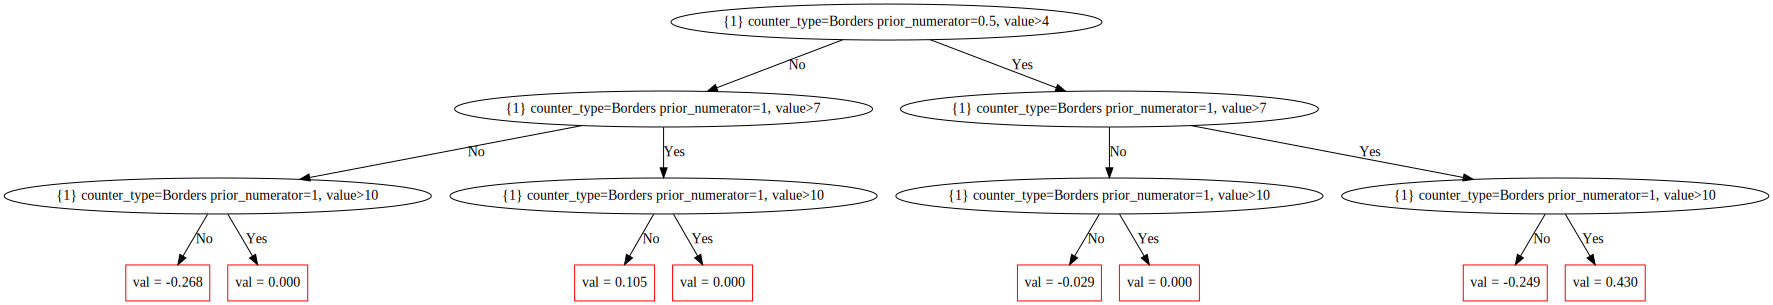

In [12]:
tb_catb.plot_tree(0)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
startTime()
ib_catb = setupModel()
ib_catb.fit(X_ib_training, y_ib_training)
endTime("CATB_Instance-Based")

#Saving Model as file
dump(ib_catb, "Outputs/"+MODEL_FILENAME+"_IB_CATB.joblib")

0:	learn: 0.5629484	total: 31.6ms	remaining: 1.55s
1:	learn: 0.4553206	total: 79.1ms	remaining: 1.9s
2:	learn: 0.3263102	total: 119ms	remaining: 1.87s
3:	learn: 0.2406946	total: 171ms	remaining: 1.96s
4:	learn: 0.1913283	total: 216ms	remaining: 1.94s
5:	learn: 0.1516025	total: 274ms	remaining: 2.01s
6:	learn: 0.1210023	total: 306ms	remaining: 1.88s
7:	learn: 0.1054110	total: 348ms	remaining: 1.82s
8:	learn: 0.0949018	total: 387ms	remaining: 1.76s
9:	learn: 0.0787895	total: 445ms	remaining: 1.78s
10:	learn: 0.0687391	total: 503ms	remaining: 1.78s
11:	learn: 0.0623236	total: 596ms	remaining: 1.89s
12:	learn: 0.0580053	total: 658ms	remaining: 1.87s
13:	learn: 0.0543990	total: 697ms	remaining: 1.79s
14:	learn: 0.0516323	total: 747ms	remaining: 1.74s
15:	learn: 0.0499895	total: 777ms	remaining: 1.65s
16:	learn: 0.0484987	total: 829ms	remaining: 1.61s
17:	learn: 0.0462357	total: 904ms	remaining: 1.61s
18:	learn: 0.0453389	total: 935ms	remaining: 1.52s
19:	learn: 0.0433856	total: 1.06s	remain

['Outputs/TUNED_TEST_IB_CATB.joblib']

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [14]:
print(classification_report(y_tb_validate, tb_catb.predict(X_tb_validate),digits=4))

              precision    recall  f1-score   support

           0     0.9985    0.9769    0.9876       692
           1     0.9770    0.9985    0.9877       681

    accuracy                         0.9876      1373
   macro avg     0.9878    0.9877    0.9876      1373
weighted avg     0.9879    0.9876    0.9876      1373



### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

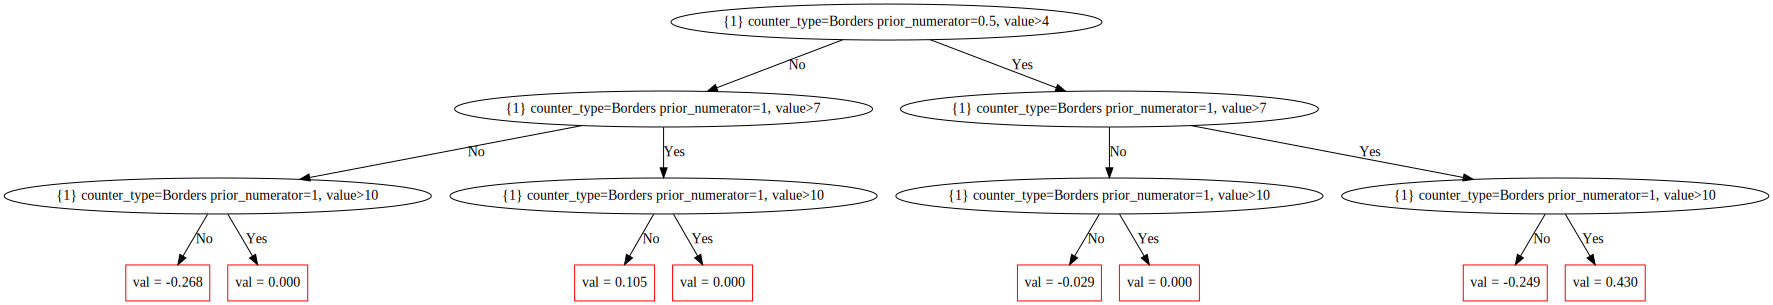

In [15]:
tb_catb.plot_tree(0)

In [16]:
logging("\n")